In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_json_to_s3

In [3]:
# Load latest player stats from S3
df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')

# Set player as index and filter for meaningful playing time
df.set_index('PLAYER', inplace=True)
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]

# Drop columns we don't want to use for clustering
df = df.drop(columns=['TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK', 'STAT_TYPE', 'SCRAPED_DATE'])

df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST RATIO,OREB%,DREB%,...,FGM_AST_PERCENT,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT
PLAYER,,,,,,,,,,,,,,,,,,,,,
bub carrington,19.0,30.0,102.8,118.0,-15.2,21.3,2.58,28.3,1.2,11.7,...,56.7,43.3,118.0,11.7,14.6,7.9,12.3,9.9,11.2,33.2
buddy hield,32.0,22.7,112.3,110.1,2.2,10.6,1.47,13.0,2.5,11.1,...,81.1,18.9,110.1,11.1,20.3,13.2,7.5,6.2,6.9,22.9
chris paul,40.0,28.0,114.2,115.0,-0.8,34.2,4.69,45.0,1.4,11.0,...,37.3,62.7,115.0,11.0,26.8,8.3,9.3,8.6,9.3,28.7
harrison barnes,33.0,27.2,114.5,115.6,-1.2,8.5,2.72,14.2,4.2,9.1,...,76.4,23.6,115.6,9.1,10.8,5.6,9.2,8.5,9.4,28.9
jaden mcdaniels,24.0,31.9,113.9,109.9,4.0,9.1,1.72,14.2,4.8,12.6,...,69.6,30.4,109.9,12.6,25.5,27.2,11.3,8.7,9.9,31.2


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST%,AST/TO,AST RATIO,OREB%,...,FGM_AST_PERCENT,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT
0,bub carrington,19.0,30.0,102.8,118.0,-15.2,21.3,2.58,28.3,1.2,...,56.7,43.3,118.0,11.7,14.6,7.9,12.3,9.9,11.2,33.2
1,buddy hield,32.0,22.7,112.3,110.1,2.2,10.6,1.47,13.0,2.5,...,81.1,18.9,110.1,11.1,20.3,13.2,7.5,6.2,6.9,22.9
2,chris paul,40.0,28.0,114.2,115.0,-0.8,34.2,4.69,45.0,1.4,...,37.3,62.7,115.0,11.0,26.8,8.3,9.3,8.6,9.3,28.7
3,harrison barnes,33.0,27.2,114.5,115.6,-1.2,8.5,2.72,14.2,4.2,...,76.4,23.6,115.6,9.1,10.8,5.6,9.2,8.5,9.4,28.9
4,jaden mcdaniels,24.0,31.9,113.9,109.9,4.0,9.1,1.72,14.2,4.8,...,69.6,30.4,109.9,12.6,25.5,27.2,11.3,8.7,9.9,31.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,keion brooks jr.,24.0,23.7,100.7,121.2,-20.5,6.2,1.08,8.8,3.4,...,79.2,20.8,121.2,13.6,19.2,35.7,9.8,8.1,8.7,24.4
350,oscar tshiebwe,25.0,18.2,113.4,115.8,-2.5,5.1,0.90,8.9,16.0,...,59.5,40.5,115.8,28.6,31.0,8.3,7.4,5.6,6.3,19.1
351,tre mann,24.0,24.5,107.0,114.4,-7.3,21.9,1.56,16.7,3.4,...,30.0,70.0,114.4,7.9,16.3,12.5,10.2,7.5,7.6,24.9
352,cole swider,26.0,17.0,114.2,100.5,13.7,2.2,0.75,4.3,2.6,...,90.9,9.1,100.5,11.9,12.9,14.3,5.2,5.6,5.1,17.4


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4704306321963428
Variance with 3 components: 0.5728415160269595
Variance with 4 components: 0.6543489425713408
Variance with 5 components: 0.7082100465017471
Variance with 6 components: 0.7548858861904182
Variance with 7 components: 0.7931267561467262
Variance with 8 components: 0.8229866337012923
Variance with 9 components: 0.8482974197893127
Variance with 10 components: 0.8706740640782767
Variance with 11 components: 0.889373660155151
Variance with 12 components: 0.9063092011232307
Variance with 13 components: 0.9209416546293356
Variance with 14 components: 0.9336948785868607
Variance with 15 components: 0.9446162716556451
Variance with 16 components: 0.9546229856413475
Variance with 17 components: 0.96275210764451
Variance with 18 components: 0.970269630196237
Variance with 19 components: 0.977065294920619
Variance with 20 components: 0.9820385525099757
Variance with 21 components: 0.9865851608256978
Variance with 22 components: 0.9902819913513102
Varia

Variance with 36 components: 0.9999999028769156
Variance with 37 components: 0.999999991534398
Variance with 38 components: 0.9999999973545399
Variance with 39 components: 1.0000000000000002
Variance with 40 components: 1.0000000000000002
Variance with 41 components: 1.0000000000000002
Variance with 42 components: 1.0000000000000002
Variance with 43 components: 1.0000000000000002
Variance with 44 components: 1.0000000000000002
Variance with 45 components: 1.0000000000000002
Variance with 46 components: 1.0000000000000002
Variance with 47 components: 1.0000000000000002
Variance with 48 components: 1.0000000000000002
Variance with 49 components: 1.0000000000000002
Variance with 50 components: 1.0000000000000002
Variance with 51 components: 1.0000000000000002
Variance with 52 components: 1.0000000000000002
Variance with 53 components: 1.0000000000000002
Variance with 54 components: 1.0000000000000002
Variance with 55 components: 1.0000000000000002
Variance with 56 components: 1.0000000000

Variance with 72 components: 1.0000000000000002
Variance with 73 components: 1.0000000000000002
Variance with 74 components: 1.0000000000000002
Variance with 75 components: 1.0000000000000002


This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

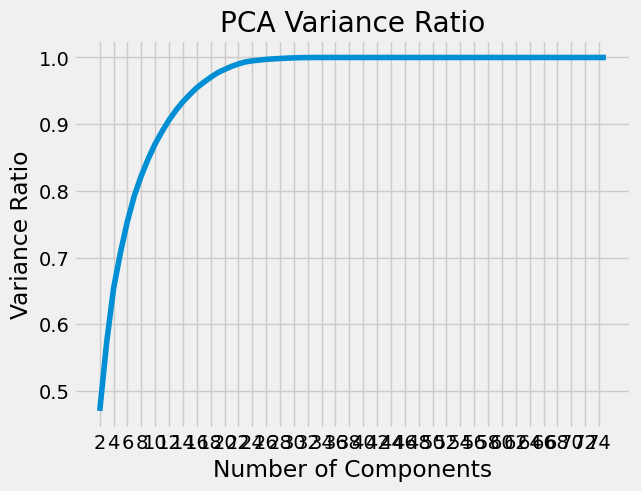

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.02410884e-01 8.15074265e-02 5.38611039e-02 4.66758397e-02
 3.82408700e-02 2.98598776e-02 2.53107861e-02 2.23766443e-02
 1.86995961e-02 1.69355410e-02 1.46324535e-02 1.27532240e-02
 1.09213931e-02 1.00067140e-02 8.12912200e-03 7.51752255e-03
 6.79566472e-03 4.97325759e-03 4.54660832e-03 3.69683053e-03
 3.00764251e-03 1.66080363e-03 1.13199495e-03 1.06920391e-03
 6.61214749e-04 6.45794953e-04 5.18984803e-04 3.96833693e-04
 3.31664566e-04 1.28294237e-04 1.09528389e-04 4.07956705e-05
 1.47647489e-05 3.90703569e-07 8.86574824e-08 5.82014192e-09
 2.64546030e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

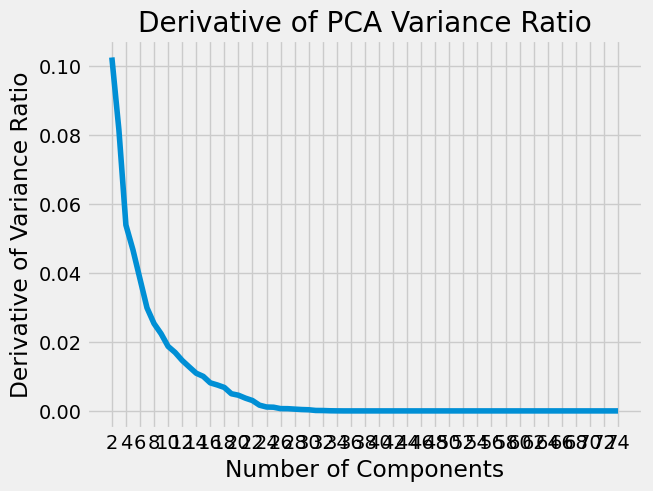

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.25069031 0.21974033 0.10241088 0.08150743 0.0538611  0.04667584
 0.03824087 0.02985988 0.02531079 0.02237664 0.0186996  0.01693554
 0.01463245 0.01275322 0.01092139 0.01000671]
0.9546229856413475


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.23538232895098235


Silhouette Score with 3 clusters: 0.20724354250648563
Silhouette Score with 4 clusters: 0.15151361990920473
Silhouette Score with 5 clusters: 0.12558870704374797
Silhouette Score with 6 clusters: 0.1335833976031214
Silhouette Score with 7 clusters: 0.1267674357892191
Silhouette Score with 8 clusters: 0.12574735454768676
Silhouette Score with 9 clusters: 0.1220006967692449
Silhouette Score with 10 clusters: 0.11283174403166127
Silhouette Score with 11 clusters: 0.10019410422937723
Silhouette Score with 12 clusters: 0.09871000698924969
Silhouette Score with 13 clusters: 0.10071266147800677
Silhouette Score with 14 clusters: 0.1037681742617725
Silhouette Score with 15 clusters: 0.10493153500785576
Silhouette Score with 16 clusters: 0.10095266183915771
Silhouette Score with 17 clusters: 0.0937528792765005
Silhouette Score with 18 clusters: 0.0944876092346411
Silhouette Score with 19 clusters: 0.08834247022635328
Silhouette Score with 20 clusters: 0.08552429748536054
Silhouette Score with 2

Silhouette Score with 22 clusters: 0.09656749717454013
Silhouette Score with 23 clusters: 0.09265350931236817
Silhouette Score with 24 clusters: 0.08728717718109244
Silhouette Score with 25 clusters: 0.08503768953799072
Silhouette Score with 26 clusters: 0.09233924106887959
Silhouette Score with 27 clusters: 0.08591409267696333
Silhouette Score with 28 clusters: 0.08314565830903047
Silhouette Score with 29 clusters: 0.08049985800272606
Silhouette Score with 30 clusters: 0.0799182655336396
Silhouette Score with 31 clusters: 0.07762139535723288


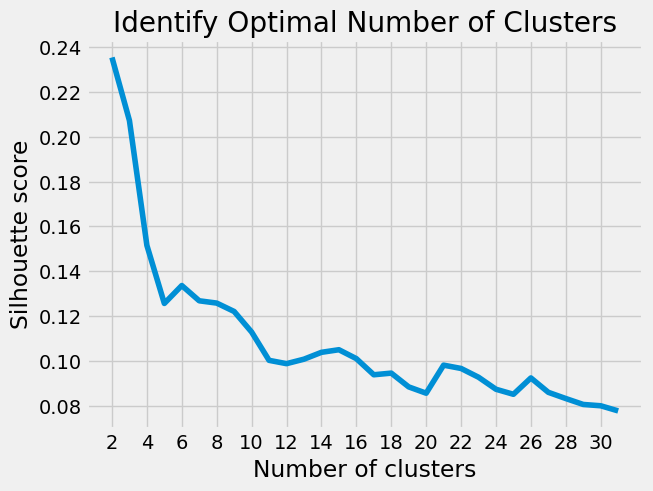

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluster = {i + 2}, improvement = {improvement}") 

for n_cluster = 3, improvement = -0.036801119709791275
for n_cluster = 4, improvement = -0.07029891976343405
for n_cluster = 5, improvement = -0.030554306437638346
for n_cluster = 6, improvement = 0.009142940654785603
for n_cluster = 7, improvement = -0.007866841188230334
for n_cluster = 8, improvement = -0.0011681667442786647
for n_cluster = 9, improvement = -0.004285554979937878
for n_cluster = 10, improvement = -0.010443006849600867
for n_cluster = 11, improvement = -0.014244918838411502
for n_cluster = 12, improvement = -0.0016493526516143664
for n_cluster = 13, improvement = 0.002221986823649491
for n_cluster = 14, improvement = 0.0033977046633255625
for n_cluster = 15, improvement = 0.0012980578380208385
for n_cluster = 16, improvement = -0.004445328289756079
for n_cluster = 17, improvement = -0.00800823522528371
for n_cluster = 18, improvement = 0.0008107390813599791
for n_cluster = 19, improvement = -0.006786366559925039
for n_cluster = 20, improvement = -0.0030912625069772215


C:\conda_tmp\ipykernel_26724\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


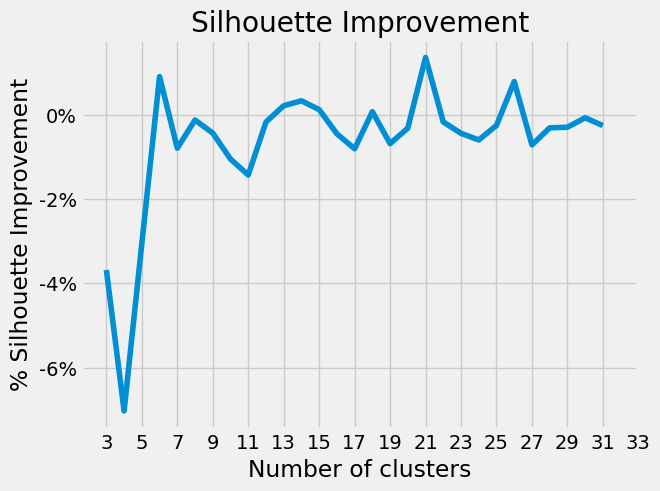

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
# with open("../models/clusterMode.sav", 'wb') as f:
#     pickle.dump(kmeans, f)

In [16]:
# Create and save cluster assignments
df_cluster = pd.DataFrame({
    'PLAYER': dfPlayerCol['PLAYER'],
    'CLUSTER': y_kmeans,
    'TIMESTAMP': pd.Timestamp.now()
})

# Save only current version to S3
save_dataframe_to_s3(df_cluster, 'data/clustered_players/current.parquet')

print("\nClustering Summary:")
print(f"Total Players: {len(df_cluster)}")
print(f"Number of Clusters: {len(np.unique(y_kmeans))}")
print(f"Silhouette Score: {silhouette_score(x, y_kmeans):.3f}")

df_cluster.head()

Saved 354 records to s3://nba-prediction-ibracken/data/clustered_players/current.parquet

Clustering Summary:
Total Players: 354
Number of Clusters: 15
Silhouette Score: 0.105


,PLAYER,CLUSTER,TIMESTAMP
0,bub carrington,3,2025-08-14 18:23:21.868386
1,buddy hield,2,2025-08-14 18:23:21.868386
2,chris paul,10,2025-08-14 18:23:21.868386
3,harrison barnes,5,2025-08-14 18:23:21.868386
4,jaden mcdaniels,9,2025-08-14 18:23:21.868386


In [17]:
# Print summary of clusters
cluster_counts = df_cluster['CLUSTER'].value_counts().sort_index()
print("\nPlayers per cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} players")


Players per cluster:
Cluster 0: 11 players
Cluster 1: 20 players
Cluster 2: 44 players
Cluster 3: 28 players
Cluster 4: 12 players
Cluster 5: 39 players
Cluster 6: 23 players
Cluster 7: 17 players
Cluster 8: 21 players
Cluster 9: 40 players
Cluster 10: 34 players
Cluster 11: 29 players
Cluster 12: 18 players
Cluster 13: 17 players
Cluster 14: 1 players
